# CS 584 Assignment 2 -- MLP and Word Vectors

#### Name: (Your Name)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement MLP.
3. Implement Word2Vec

*** Please read the code and comments very carefully and install these packages (NumPy, Pandas, sklearn, tqdm, spacy, and matplotlib) before you start ***

In [1]:
###############################################################
#                                                             #
#    Run this cell to make sure all packages are installed.   #
#                                                             #
###############################################################

# %pip install numpy pandas scikit-learn tqdm matplotlib
import pandas as pd
%pip install -U spacy
%python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


## 1. MLP (30 points)
In this section, you are required to implement the MLP in the following steps.
1. Data Processing (Same as assignment 1, you could directly use your code in assignment 1.)
2. MLP
3. Evaluation

### 1.1 Data Processing

#### load data

In [8]:
import pandas as pd

# training data
train_df = pd.read_csv('./data/train.csv', header=None)
train_df.columns = ['label', 'title', 'text']

# test data
test_df = pd.read_csv('./data/test.csv', header=None)
test_df.columns = ['label', 'title', 'text']

####  Preprocessing

In [3]:
import re
import string

class Preprocesser(object):
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number
    
    def apply(self, text):
        
        text = self._lowercase(text)
        
        if self.url:
            text = self._remove_url(text)
            
        if self.punctuation:
            text = self._remove_punctuation(text)
            
        if self.number:
            text = self._remove_number(text)
        
        text = re.sub(r'\s+', ' ', text)
            
        return text
    
        
    def _remove_punctuation(self, text):
        ''' Please fill this function to remove all the punctuations in the text
        '''
        ### Start your code
        text = text.translate(str.maketrans('','', string.punctuation)) 
        ### End
        
        return text
    
    def _remove_url(self, text):
        ''' Please fill this function to remove all the urls in the text
        '''
        ### Start your code
        url_pattern = re.compile("(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})")
        text = url_pattern.sub('', text)
        ### End
        
        return text
    
    def _remove_number(self, text):
        ''' Please fill this function to remove all the numbers in the text
        '''
        
        ### Start your code        
        text = text.translate(str.maketrans('','',string.digits))
        ### End
        
        return text
    
    def _lowercase(self, text):
        ''' Please fill this function to lower the text
        '''
        
        ### Start your code
        text = text.lower()        
        ### End
        
        return text


#### Tokenization

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    ''' Please fill this function to tokenize text.
            1. Tokenize the text.
            2. Remove stop words.
            3. Optional: lemmatize words accordingly.
    '''
    
    ### Start your code
    text = nlp(text)
    tokens = [token.lemma_ for token in text if not token.is_stop]
    ### End
    
    return tokens

In [5]:
import nltk

def tokenize(text):
    ''' Please fill this function to tokenize text.
            1. Tokenize the text.
            2. Remove stop words.
            3. Optional: lemmatize words accordingly.
    '''
    
    ### Start your code
    tokens = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    ### End
    
    return tokens

In [6]:
text = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processer = Preprocesser()
clean_text = processer.apply(text)

tokens = tokenize(clean_text)

print(f'{text} ==> {tokens}')


Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets. ==> ['interest', 'rate', 'trimmed', 'south', 'african', 'central', 'bank', 'lack', 'warning', 'hit', 'rand', 'surprise', 'market']


#### Data Split

In [9]:
from sklearn.model_selection import train_test_split

text_train = train_df['text'].values.astype(str)
label_train = train_df['label'].values.astype(int) - 1 # -1 because labels start from 1

text_test = test_df['text'].values.astype(str)
label_test = test_df['label'].values.astype(int) - 1 # -1 because labels start from 1


text_train, text_valid, label_train, label_valid = train_test_split(text_train, label_train, test_size=0.2)


print('The size of training set:', text_train.shape[0])
print('The size of validation set:', text_valid.shape[0])
print('The size of testing set:', text_test.shape[0])

The size of training set: 96000
The size of validation set: 24000
The size of testing set: 7600


#### Feature Extraction

In [10]:
from collections import defaultdict, Counter
import numpy as np
from tqdm.notebook import tqdm

class TfIdfExtractor(object):
    
    def __init__(self, vocab_size=None):
        self.vocab_size = vocab_size
        
        self.vocab = defaultdict(lambda: 0)
        self.word2idx = {}
        self.df = defaultdict(lambda: 0)
        self.num_doc = 0
        
        self.processer = Preprocesser()
        
        
    def fit(self, texts):
        ''' In this function, you are required to implement the fitting process.
                1. Construct the vocabulary (self.vocab).
                2. Construct the document frequency dictionary (self.df).
                3. Sort the tokens(the keys in self.vocab) based on the frequence (the values of self.vocab).
            Input:
                texts: a list of text (training set)
            Output:
                None
        '''

        self.num_doc = len(texts)
        
        for text in tqdm(texts, desc='fitting text'):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)
            ### Start your code (step 1 & 2)
            tokens_counter = Counter(tokens)
            for i,j in tokens_counter.items():
                self.vocab[i] += j
                self.df[i] += 1
            ### End
        
        ### Start your code (Step 3)
        self.vocab = {i:j for i,j in sorted(self.vocab.items(), key=lambda x:x[1], reverse=True)}
        ### End
        
        
        if self.vocab_size is not None:
            self.vocab = {key: self.vocab[key] for key in list(self.vocab.keys())[:self.vocab_size]}
        
        self.word2idx = {key: idx for idx, key in enumerate(self.vocab.keys())}


    def transform(self, texts):
        ''' In this function, you need to encode the input text into TF-IDF vector.
            Input:
                texts: a list of text.
            Ouput:
                a N-d matrix (Tf-Idf) 
        '''
        tfidf = np.zeros((len(texts), len(self.vocab)))
        
        for i, text in tqdm(enumerate(texts), desc='transforming', total=len(texts)):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)
            
            ### Start your code
            tokens_counter = Counter(tokens)

            for token, counter in tokens_counter.items():
                if token in self.vocab:
                    tfidf[i][self.word2idx[token]] = counter/min(len(tokens),self.vocab_size)

        idf_values = np.zeros((self.vocab_size))

        for i,j in self.df.items():
            if i in self.vocab:
                idf_values[self.word2idx[i]] = np.log((self.num_doc + 1)/(j + 1))+1
                
        tfidf = tfidf*idf_values[None:,]

                
            ### End
        
        return tfidf

    ### NEED TO BE REMOVED
    def _tf_idf(self, token, tokens):
        tf = tokens.count(token) / len(tokens)
        idf = np.log(self.num_doc / self.df[token])
        return tf * idf
    

#### Obtain the outputs

In [11]:
# You can change this number to see the difference of the performances. (larger vocab size needs more memory)
vocab_size = 4000 
num_class = 4

extractor = TfIdfExtractor(vocab_size=vocab_size)
extractor.fit(text_train)

x_train = extractor.transform(text_train)
x_valid = extractor.transform(text_valid)
x_test = extractor.transform(text_test)


# convert label to one-hot vector
y_train = np.zeros((label_train.shape[0], num_class))
y_train[np.arange(label_train.shape[0]), label_train] = 1

y_valid = np.zeros((label_valid.shape[0], num_class))
y_valid[np.arange(label_valid.shape[0]), label_valid] = 1

y_test = np.zeros((label_test.shape[0], num_class))
y_test[np.arange(label_test.shape[0]), label_test] = 1


print('The size of training set:', x_train.shape)
print('The size of validation set:', x_valid.shape)
print('The size of test set:', x_test.shape)

fitting text:   0%|          | 0/96000 [00:00<?, ?it/s]

transforming:   0%|          | 0/96000 [00:00<?, ?it/s]

transforming:   0%|          | 0/24000 [00:00<?, ?it/s]

transforming:   0%|          | 0/7600 [00:00<?, ?it/s]

The size of training set: (96000, 4000)
The size of validation set: (24000, 4000)
The size of test set: (7600, 4000)


### 1.2 MLP (30 points)

In this section, you are required to implement a 1-layer MLP from scratch.

#### 1.2.1 Implement MLP (fill the code: 20 points)

> $z_1 = w_1x$

> $h_1 = activation(z_1)$

> $z_2 = w_2 h_1$

> $\hat{y} = softmax(z_2)$

In [40]:
class MLP(object):
    
    def __init__(self, num_feature, hidden_size, num_class):
        ''' Initialize the weight of MLP.
            Inputs:
                num_feature: scalar, the number of features (in this case, it is the vocab size).
                hidden_size: scaler, the number of neurons in the hidden layer.
                num_class: scalar, the number of classes.
        '''
        
        ### Start your code
        # self.w1 = np.random.rand(hidden_size, num_feature+1)
        self.w1 = np.random.rand(hidden_size, num_feature)
        # self.w2 = np.random.rand(num_class, hidden_size+1)
        self.w2 = np.random.rand(num_class, hidden_size)
        ### End
        
        
    def forward(self, x):
        ''' Implement the forward pass.
            Input:
                x: N-d matrix
            Outputs
                y_hat: the output of the model, N-K matrix.
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
                
                Note that the reason for return h1 and z1 is for calculating the gradient of self.w1 and self.w2.
                Feel free to change it accordingly.
        '''
        
        ### Start your code
        # x = np.hstack((np.ones((x.shape[0], 1)), x))
        z1 = np.matmul(x, self.w1.T)
        h1 = self.activation(z1)

        # h1 = np.hstack((np.ones(((h1.shape[0], 1))), h1))
        z2 = np.matmul(h1, self.w2.T)
        y_hat = self.softmax(z2)
        ### End
        
        return y_hat, (h1, z1)
    
    
    def backward(self, lr, x, y, y_hat, h1, z1):
        ''' Implement back-propagation.
            Inputs:
                lr: learning rate.
                x: the input, N-d matrix.
                y_hat: the output, N-K matrix.
                y: ground truth (N-K one-hot matrix).
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
        '''

        # Get the gradient of w1 and w2
        grad_w1, grad_w2 = self.gradient(x, y, y_hat, h1, z1)
        
        # Gradient descent
        self.w1 -= lr * grad_w1
        self.w2 -= lr * grad_w2
        
    
    def objective(self, y, y_hat):
        ''' Compute the loss
            Inputs:
                y: N-K matrix, ground truth.
                y_hat: N-K matrix, prediction.
            Output:
                loss: scalar, the loss of the model.
        '''
        
        loss = 0.
        
        ### Start your code
        loss = -np.mean(np.sum(y * np.log(y_hat),axis=1))
        ### End
        
        return loss
    
    
    def gradient(self, x, y, y_hat, h1, z1):
        ''' Compute the gradient of self.w1 and self.w2
            Inputs:
                x: the input, N-d matrix.
                y_hat: the output, N-K matrix.
                y: ground truth (N-K one-hot matrix).
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
            Outputs:
                grad_w1: the gradient of self.w1.
                grad_w2: the gradient of self.w2.
        '''
        n = x.shape[0]
        
        grad_w1 = 0. # 0 is a placeholder, the actual value should be a matrix
        grad_w2 = 0. # 0 is a placeholder, the actual value should be a matrix
        
        ### Start your code
        dz2 = y_hat - y
        grad_w2 = (1/n)*np.matmul(dz2.T, h1)

        dz1 = np.multiply(np.matmul(dz2, self.w2), (z1>0).astype('int'))
        grad_w1 = (1/n)*np.matmul(dz1.T, x)
        
        ### End
        
        return grad_w1, grad_w2
    
    
    def activation(self, x):
        ''' Implement an activation function, ReLU or Sigmoid.
            Please note that for different activation functions, 
            you have to implement different gradient in function "backward()"
            
            Input:
                x: N-d matrix
            Output:
                x: sigmoid(x) or ReLU(x)
        '''
        
        ### Start your code
        x = np.maximum(x,0)
        # x = 1 / (1 + np.exp(-x))
        ### End
        
        return x
    
    
    def softmax(self, x):
        if len(x.shape) == 1:
            x = x - np.max(x)
            return np.exp(x) / np.sum(np.exp(x))
        else:
            x = x - np.max(x, axis=1).reshape(-1, 1)
        return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)

    
    

#### Gradient Checking
Please run the following cell to do the gradient checking. This block will check your implementation of calculating the gradient of w1 and w2. Make sure you pass this test, otherwise you can not train your model correctly.

**Note that** if you don't pass this test case, please check the functions **"MLP.gradient()"** and **"MLP.objective()"** very carefully.

In [41]:
###############################################
#                                             #
#   Checking functions below. DO NOT MODIFY   #
#                                             #
###############################################
def gradient_checking(model, X, y, epsilon):    
    y_hat, (h1, z1) = model.forward(X)
    grad_w1, grad_w2 = model.gradient(X, y, y_hat, h1, z1)
    
    it = np.nditer(model.w2, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        model.w2[ix] += epsilon # increment by eps
        y_hat, _ = model.forward(X)
        l1 = model.objective(y, y_hat)
        
        model.w2[ix] -= 2 * epsilon # restore to previous value (very important!)
        y_hat, _ = model.forward(X)
        l2 = model.objective(y, y_hat)
        
        model.w2[ix] += epsilon
        numgrad = (l1 - l2) / 2 / epsilon

        # Compare gradients
        reldiff = abs(numgrad - grad_w2[ix])
        if reldiff > 1e-4:
            print("Gradient check failed for w2.")
            print("First gradient error found at index %s in the vector of gradients" % str(ix))
            print("Your gradient: %f \t Numerical gradient: %f" % (
                grad_w2[ix], numgrad))
            return

        it.iternext() # Step to next dimension
        
    it = np.nditer(model.w1, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        model.w1[ix] += epsilon # increment by eps
        y_hat, _ = model.forward(X)
        l1 = model.objective(y, y_hat)
        
        model.w1[ix] -= 2 * epsilon # restore to previous value (very important!)
        y_hat, _ = model.forward(X)
        l2 = model.objective(y, y_hat)
        
        model.w1[ix] += epsilon
        numgrad = (l1 - l2) / 2 / epsilon

        # Compare gradients
        reldiff = abs(numgrad - grad_w1[ix])
        if reldiff > 1e-4:
            print("Gradient check failed for w1.")
            print("First gradient error found at index %s in the vector of gradients" % str(ix))
            print("Your gradient: %f \t Numerical gradient: %f" % (
                grad_w1[ix], numgrad))
            return

        it.iternext() # Step to next dimension
        
    print("Gradient check passed!")
    
epsilon = 1E-4
np.random.seed(10)
dummy_X = np.random.rand(10, 5)
dummy_y = np.eye(3)[np.random.choice(3, 10)]
dummy_model = MLP(5, 3, 3)
gradient_checking(dummy_model, dummy_X, dummy_y, epsilon)

Gradient check passed!


#### 1.2.2 Optimization (Fill the code: 10 points)

In this section, you are requried to call the MLP model to implement the Mini-batch GD.

In [44]:
def optimization(model, X, y, lr, batch_size=None, num_epoch=100):
    ''' Implement Mini-batch GD
        Inputs:
            X: N-d matrix
            y: N vector
            lr: learning rate
            batch_size: optional, depends on if you use Mini-batch GD
            num_epoch: the number of epochs
        Output:
            A list of training losses against epoch
            A list of validation losses against epoch
    '''
    train_losses = []
    valid_losses = []
    
    n, _ = X.shape
    
    for e in range(num_epoch):
        train_loss = 0.
        
        losses = []
        
        rand_indices = np.random.permutation(n)
        x_rand = X[rand_indices]
        y_rand = y[rand_indices]
        
        for b in tqdm(range(0, n, batch_size), f'Epoch {e+1}/{num_epoch}'):
            x_batch = x_rand[b: b+batch_size] 
            y_batch = y_rand[b: b+batch_size]
            
            ### Start your code
            
            ### Step 1, call forward function to get outputs
            y_hat, (h1, z1) = model.forward(x_batch)
            
            ### Step 2, call objective function to get loss
            loss = model.objective(y_batch, y_hat)
            
            ### Step 3, call backward to update the weights
            model.backward(lr, x_batch, y_batch, y_hat, h1, z1)
            
            # End
            
            losses.append(loss)
        
        train_loss = np.mean(losses)
        
        
        y_hat, _ = model.forward(x_valid)
        valid_loss = model.objective(y_valid, y_hat)
        
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'At epoch {e+1}, training loss: {train_loss:.4f}, validation loss: {valid_loss:.4f}.')
            
    return train_losses, valid_losses

#### Run the following cell to train the model. (Feel free to tune the hpyer-parameters)

In [45]:
num_epoch = 50
lr = 0.001
batch_size = 32
hidden_size = 50

model = MLP(vocab_size, hidden_size, num_class)
train_losses, valid_losses = optimization(model, x_train, y_train, lr, batch_size=batch_size, num_epoch=num_epoch)

Epoch 1/50:   0%|          | 0/3000 [00:01<?, ?it/s]

At epoch 1, training loss: 1.5987, validation loss: 1.5287.


Epoch 2/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 2, training loss: 1.4879, validation loss: 1.4550.


Epoch 3/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 3, training loss: 1.4201, validation loss: 1.3919.


Epoch 4/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 4, training loss: 1.3667, validation loss: 1.3456.


Epoch 5/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 5, training loss: 1.3237, validation loss: 1.3073.


Epoch 6/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 6, training loss: 1.2881, validation loss: 1.2759.


Epoch 7/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 7, training loss: 1.2577, validation loss: 1.2461.


Epoch 8/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 8, training loss: 1.2316, validation loss: 1.2230.


Epoch 9/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 9, training loss: 1.2080, validation loss: 1.2016.


Epoch 10/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 10, training loss: 1.1864, validation loss: 1.1782.


Epoch 11/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 11, training loss: 1.1661, validation loss: 1.1611.


Epoch 12/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 12, training loss: 1.1468, validation loss: 1.1400.


Epoch 13/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 13, training loss: 1.1282, validation loss: 1.1212.


Epoch 14/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 14, training loss: 1.1099, validation loss: 1.1069.


Epoch 15/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 15, training loss: 1.0922, validation loss: 1.0884.


Epoch 16/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 16, training loss: 1.0751, validation loss: 1.0697.


Epoch 17/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 17, training loss: 1.0579, validation loss: 1.0549.


Epoch 18/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 18, training loss: 1.0410, validation loss: 1.0379.


Epoch 19/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 19, training loss: 1.0247, validation loss: 1.0208.


Epoch 20/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 20, training loss: 1.0083, validation loss: 1.0062.


Epoch 21/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 21, training loss: 0.9925, validation loss: 0.9883.


Epoch 22/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 22, training loss: 0.9769, validation loss: 0.9742.


Epoch 23/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 23, training loss: 0.9616, validation loss: 0.9578.


Epoch 24/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 24, training loss: 0.9468, validation loss: 0.9439.


Epoch 25/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 25, training loss: 0.9323, validation loss: 0.9301.


Epoch 26/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 26, training loss: 0.9180, validation loss: 0.9157.


Epoch 27/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 27, training loss: 0.9044, validation loss: 0.9035.


Epoch 28/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 28, training loss: 0.8910, validation loss: 0.8890.


Epoch 29/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 29, training loss: 0.8781, validation loss: 0.8756.


Epoch 30/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 30, training loss: 0.8656, validation loss: 0.8658.


Epoch 31/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 31, training loss: 0.8533, validation loss: 0.8523.


Epoch 32/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 32, training loss: 0.8417, validation loss: 0.8399.


Epoch 33/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 33, training loss: 0.8304, validation loss: 0.8290.


Epoch 34/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 34, training loss: 0.8194, validation loss: 0.8187.


Epoch 35/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 35, training loss: 0.8089, validation loss: 0.8078.


Epoch 36/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 36, training loss: 0.7985, validation loss: 0.7987.


Epoch 37/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 37, training loss: 0.7887, validation loss: 0.7895.


Epoch 38/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 38, training loss: 0.7792, validation loss: 0.7791.


Epoch 39/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 39, training loss: 0.7700, validation loss: 0.7708.


Epoch 40/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 40, training loss: 0.7611, validation loss: 0.7616.


Epoch 41/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 41, training loss: 0.7524, validation loss: 0.7532.


Epoch 42/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 42, training loss: 0.7443, validation loss: 0.7450.


Epoch 43/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 43, training loss: 0.7363, validation loss: 0.7374.


Epoch 44/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 44, training loss: 0.7288, validation loss: 0.7306.


Epoch 45/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 45, training loss: 0.7213, validation loss: 0.7225.


Epoch 46/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 46, training loss: 0.7140, validation loss: 0.7166.


Epoch 47/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 47, training loss: 0.7071, validation loss: 0.7099.


Epoch 48/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 48, training loss: 0.7004, validation loss: 0.7035.


Epoch 49/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 49, training loss: 0.6939, validation loss: 0.6989.


Epoch 50/50:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 50, training loss: 0.6877, validation loss: 0.6913.


#### 1.2.3 Evaluation

#### Run the following cell to evaluate the performance of your model

In [46]:
from sklearn.metrics import precision_score, recall_score

y_hat, _ = model.forward(x_test)
y_hat = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)

print(y_true.shape)
precision = precision_score(y_true, y_hat, average=None)
recall = recall_score(y_true, y_hat, average=None)

print('MLP')
print()
print('  Precision:')
print(f'    class {0}: {precision[0]:.4f}, class {1}: {precision[1]:.4f}, class {2}: {precision[2]:.4f}, class {3}: {precision[3]:.4f}')
print()
print('  Recall:')
print(f'    class {0}: {recall[0]:.4f}, class {1}: {recall[1]:.4f}, class {2}: {recall[2]:.4f}, class {3}: {recall[3]:.4f}')

(7600,)
MLP

  Precision:
    class 0: 0.7560, class 1: 0.7869, class 2: 0.6902, class 3: 0.7305

  Recall:
    class 0: 0.7747, class 1: 0.8495, class 2: 0.7316, class 3: 0.6105


#### Run the following cell to plot the training loss and validation loss against epoch

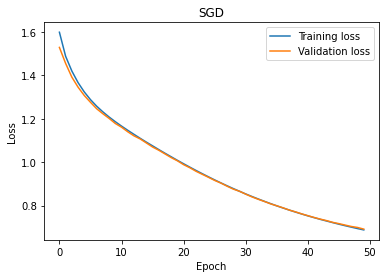

In [47]:
import matplotlib.pyplot as plt

%matplotlib inline


plt.plot(range(num_epoch), train_losses, valid_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('SGD')
plt.show()

## 2. Word Vector (70 points)

In this section, you are required to implement a Word2Vec model.

### 2.1 Written Questions (25 points, each question is 5 points. )


To better understand the insight of Word2Vec, Please answer the following questions. (You can either answer those questions in this notebook, or submit a pdf with your answers.)

1. Derive the gradients of the sigmoid function and show that it can be rewritten as a function of the function value (i.e., in some expressions where only $\sigma(x)$, but not $x$, is present). Assume that the input $x$ is a scalar for this question. Recall, the sigmoid function is:

$$\sigma(x) = \frac{1}{1+e^{-x}}$$


2. Assume you are given a predicted word vector $\mathbf{v}_c$ corresponding to the center word $c$ for skipgram, and the word prediction is made with the **softmax** function，

<center>$\hat{y}_o = p(o|c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{\sum_{w=1}^W \exp(\mathbf{u}_w^\top\mathbf{v}_c)}$</center>

> where $o$ is the expected word, $w$ denotes the $w$-th word and $\mathbf{u}_w$ (w = 1, ..., W) are the “output” word vectors for all words in the vocabulary.
The cross entropy function is defined as:

<center>$J_\text{CE}(o,\mathbf{v}_c, U) =CE(\mathbf{y}, \hat{\mathbf{y}})= -\sum_i y_i \log(\hat{y}_i)$</center>

> where the gold vector $\mathbf{y}$ is a one-hot vector, the softmax prediction vector $\hat{\mathbf{y}}$ is a
probability distribution over the output space, and $U= [u_1, u_2, ..., u_W]$ is the matrix of all the output vectors. 
Assume cross entropy cost is applied to this prediction, derive the gradients with respect to $\mathbf{v}_c$.

3. Derive gradients for the "output" word vector $\mathbf{u}_w$ (including $\mathbf{u}_o$) in the previous part.


4. Repeat (2) and (3) assuming we are using the negative sampling loss for the predicted vector $\mathbf{v}_c$. Assume that K negative samples (words) are drawn and they are 1,...,K respectively. For simplicity of notation, assume ($o\notin \{1,...,K\}$). Again for a given word $o$, use $\mathbf{u}_o$ to denote its output vector. The negative sampling loss function in this case is:
$$J_\text{neg-sample}(o,\mathbf{v}_c, U) =-\log(\sigma(\mathbf{u}_o^\top \mathbf{v}_c)) -\sum_{k=1}^K \log(\sigma(-\mathbf{u}_k^\top \mathbf{v}_c))$$

5. Derive gradients for all of the word vectors for skip-gram given the previous parts and given a set of context words $[\text{word}_{c-m}, . . . , \text{word}_c, . . . , \text{word}_{c+m}]$ where $m$ is the
context size. Denote the "input" and "output" word vectors for word $k$ as $\mathbf{v}_k$ and $\mathbf{u}_k$ respectively.

> _Hint: feel free to use $F(o, \mathbf{v}_c)$ (where $o$ is the expected word) as a placeholder for the $J_\text{CE}(o,\mathbf{v}_c ...)$ or $J_\text{neg-sample}(o,\mathbf{v}_c...)$ cost functions in this part -- you’ll see that this is a useful abstraction for the coding part. That is, your solution may contain terms of the form $\frac{\partial F(o, \mathbf{v}_c)}{\partial ...}$ Recall that for skip-gram, the cost for a context centered around c is:
$$\sum_{-m \leq j\leq m, j\neq0} F(w_{c+j}, \mathbf{v}_c)$$_

### 2.2 Coding (45 points)

#### 2.2.1 Sigmoid Function (Fill the code: 5 points)

In [70]:
def sigmoid(x):
    ''' Compute the sigmoid function.
        Inputs:
            x: A scalar or numpy array
        Outputs:
            s: sigmoid(x)
    '''
    s = 0.
    
    ### Start your code
    s = 1 / (1 + np.exp(-x))
    ### End
    
    return s


def softmax(x):
    ''' Compute the softmax function for each row of the input x. 
        It is crucial that this function is optimized for speed 
        because it will be used frequently in later code. 

        Inputs:
        x: A D dimensional vector or N x D dimensional numpy matrix.
        Outputs:
        x: You are allowed to modify x in-place
    '''
    if len(x.shape) == 1:
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    else:
        x = x - np.max(x, axis=1).reshape(-1, 1)
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
    

#### 2.2.2 Word2Vec models with Stochastic gradient descent (SGD)

#### Naive Softmax loss & gradient function for word2vec models (fill the code: 10 points)

In [71]:
def naiveSoftmaxLossAndGradient(centerWordVec, outsideWordIdx, outsideVectors, dataset):
    ''' Implement tha naive softmax loss and gradients between a center word's embedding 
        and an outside word's embedding. This will be the building block for our word2vec
        models.
        
        Inputs:
            centerWordVec: numpy ndarray, center word's embedding (v_c in question 2.1.1).
            outsideWordIdx: integer, the index of the outside word (o of u_o in question 2.1.1).
            outsideVectors: outside vectors (rows of matrix) for all words in vocab (U in question 2.1.1).
            dataset: for negative sampling, ignore this argument in this function.
        
        Outputs:
            loss: naive softmax loss
            gradCenterVec: the gradient with respect to the center word vector (dJ/dv_c in question 2.1.1).
            gradOutsideVecs: the gradient with respect to all the outside word vectors (dJ / dU).
    '''
    
    ### Start your code (Please use the provided softmax function)
    y_hat = softmax(outsideVectors@centerWordVec)
    loss = -np.log(y_hat[outsideWordIdx])
    y_hat[outsideWordIdx] -= 1.0
    gradCenterVec = outsideVectors.T@y_hat
    gradOutsideVecs = np.outer(y_hat,centerWordVec)
    ### End
    
    return loss, gradCenterVec, gradOutsideVecs

#### Negative sampling loss function for word2vec models (Fill the code: 10 points)

In [72]:
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

def negSamplingLossAndGradient(centerWordVec, outsideWordIdx, outsideVectors, dataset, K=10):
    ''' Implement the negative sampling loss and gradients for a centerWordVec
        and a outsideWordIdx word vector as a building block for word2vec
        models. K is the number of negative samples to take.

        Note: The same word may be negatively sampled multiple times. For
        example if an outside word is sampled twice, you shall have to
        double count the gradient with respect to this word. Thrice if
        it was sampled three times, and so forth.

        Inputs/Outpus Specifications: same as naiveSoftmaxLossAndGradient
    '''
    
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices
    
    ### Start your code (Please use your implementation of sigmoid)
    gradCenterVec, gradOutsideVecs = np.zeros(centerWordVec.shape),np.zeros(outsideVectors.shape)
    
    y_hat = sigmoid(np.dot(outsideVectors[outsideWordIdx],centerWordVec))
    loss = -np.log(y_hat)
    gradCenterVec += outsideVectors[outsideWordIdx] * (y_hat - 1.0)
    gradOutsideVecs[outsideWordIdx] = centerWordVec * (y_hat - 1.0)
    
    for i in range(K):
        y_hat = sigmoid(-np.dot(outsideVectors[indices[i+1]],centerWordVec))
        loss -= np.log(y_hat)
        gradCenterVec += outsideVectors[indices[i+1]] * (1.0 - y_hat)
        gradOutsideVecs[indices[i+1]] += centerWordVec * (1.0 - y_hat)

    
    ### End
    
    return loss, gradCenterVec, gradOutsideVecs


#### Skip-gram model in word2vec (Fill the code, 10 points)

In [73]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    ''' Implement the skip-gram model in this function.
    
        Inputs:
            currentCenterWord: a string of the current center word
            windowSize: integer, context window size
            outsideWords: list of no more than 2*windowSize strings, the outside words
            word2Ind: a dictionary that maps words to their indices in
                      the word vector list
            centerWordVectors: center word vectors (as rows) for all words in vocab
                                (V in pdf handout)
            outsideVectors: outside word vectors (as rows) for all words in vocab
                            (U in pdf handout)
            word2vecLossAndGradient: the loss and gradient function for
                                       a prediction vector given the outsideWordIdx
                                       word vectors, could be one of the two
                                       loss functions you implemented above.

        Outputs:
            loss: the loss function value for the skip-gram model
                    (J in the pdf handout)
            gradCenterVecs: the gradient with respect to the center word vectors
                    (dJ / dV in the pdf handout)
            gradOutsideVectors: the gradient with respect to the outside word vectors
                                (dJ / dU in the pdf handout)
    '''
    
    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    # Start your code
    i = word2Ind[currentCenterWord]
    centerWordVec = centerWordVectors[i]
    
    for ow in outsideWords:
        j = word2Ind[ow]
        ls, cnt_grad, out_grad = word2vecLossAndGradient(centerWordVec, j, outsideVectors, dataset)
        loss += ls
        gradCenterVecs[i] += cnt_grad
        gradOutsideVectors += out_grad
    # End

    return loss, gradCenterVecs, gradOutsideVectors



def normalizeRows(x):
    """ Row normalization function

    Implement a function that normalizes each row of a matrix to have
    unit length.
    """
    N = x.shape[0]
    x /= np.sqrt(np.sum(x**2, axis=1)).reshape((N, 1)) + 1e-30
    return x


def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2), :]
    outsideVectors = wordVectors[int(N/2):, :]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

#### Run the following cell to test your implementations

In [74]:
#############################################
# Testing functions below. DO NOT MODIFY!   #
############################################

import random
import numpy as np

from utils.gradcheck import gradcheck_naive


def test_word2vec():
    """ Test the two word2vec implementations, before running on Stanford Sentiment Treebank """
    dataset = type('dummy', (), {})()

    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0, 4)], \
            [tokens[random.randint(0, 4)] for i in range(2*C)]
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10, 3))
    dummy_tokens = dict([("a", 0), ("b", 1), ("c", 2), ("d", 3), ("e", 4)])

    print("==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, naiveSoftmaxLossAndGradient),
        dummy_vectors, "naiveSoftmaxLossAndGradient Gradient")

    print("==== Gradient check for skip-gram with negSamplingLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, negSamplingLossAndGradient),
        dummy_vectors, "negSamplingLossAndGradient Gradient")

    print("\n=== Results ===")
    print("Skip-Gram with naiveSoftmaxLossAndGradient")

    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\nGradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 3, ["a", "b", "e", "d", "b", "c"],
                  dummy_tokens, dummy_vectors[:5, :], dummy_vectors[5:, :], dataset)
    )
    )

    print("Expected Result: Value should approximate these:")
    print("""Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]
    """)

    print("Skip-Gram with negSamplingLossAndGradient")
    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\n Gradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5, :],
                  dummy_vectors[5:, :], dataset, negSamplingLossAndGradient)
    )
    )
    print("Expected Result: Value should approximate these:")
    print("""Loss: 16.15119285363322
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-4.54650789 -1.85942252  0.76397441]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
 Gradient wrt Outside Vectors (dJ/dU):
 [[-0.69148188  0.31730185  2.41364029]
 [-0.22716495  0.10423969  0.79292674]
 [-0.45528438  0.20891737  1.58918512]
 [-0.31602611  0.14501561  1.10309954]
 [-0.80620296  0.36994417  2.81407799]]
    """)
    
test_word2vec()

==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====
Gradient check passed!
==== Gradient check for skip-gram with negSamplingLossAndGradient ====
Gradient check passed!

=== Results ===
Skip-Gram with naiveSoftmaxLossAndGradient
Your Result:
Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]

Expected Result: Value should approximate these:
Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0

#### 2.2.3 K-nearest neighbors. (Fill the code: 10 points)

In [76]:
def cosine_similartiy(v1, v2):
    ''' return the cosine similarity of two vectors
        
        Inputs:
            v1: a numpy ndarray
            v2: a numpy ndarray
        Outputs:
            s: the cosine similarity of v1 and v2
    '''
    
    ### Start your code
    s = np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))    
    ### End
    
    return s

def knn(vec, mat, k):
    ''' Implement the KNN algorithm, which will be used for analysis.
        
        Inputs:
            vec: numpy ndarray, the target vector
            mat: numpy ndarray, a matrix contains all the vectors (each row is a vector)
            k: the number of the nearest neighbors you want to find.
            
        Outputs:
            indices: the k indices of the matrix's rows that are closest to the vec
    '''
                          
    ### Start your code
    scores = np.array([cosine_similartiy(vec, v2) for v2 in mat])
    indices = (-scores).argsort()[:k]                      
    ### End
    
    return indices

#### 2.2.4 Evalution the model with visualization and knn

#### Run the following cell to train the word2vec model

_Note: The training process may take a long time depending on the efficiency of your implementation. Plan accordingly!_

In [77]:
import os.path as op
import numpy as np
import random
import glob
import pickle

import time
from utils.treebank import StanfordSentiment

SAVE_PARAMS_EVERY = 5000


def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)


def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=1000):
    """ Stochastic Gradient Descent

    Implement the stochastic gradient descent method in this function.

    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss

    Return:
    x -- the parameter value after SGD finishes
    """

    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        def postprocessing(x): return x

    exploss = None

    last_time = time.time()
    for iter in range(start_iter + 1, iterations + 1):
        # You might want to print the progress every few iterations.

        loss = None
        loss, g = f(x)
        x -= step * g

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f, duration %d" % (iter, exploss, int(time.time() - last_time)))
            last_time = time.time()

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

In [78]:
import time
from utils.treebank import StanfordSentiment

random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)


# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)

startTime = time.time()
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
     dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)

wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
                                     negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=100)

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

tokenizing:   0%|          | 0/10000 [00:00<?, ?it/s]

iter 100: 20.281331, duration 61
iter 200: 20.510079, duration 39
iter 300: 20.414788, duration 31
iter 400: 20.682585, duration 31
iter 500: 20.929418, duration 35
iter 600: 21.179112, duration 34
iter 700: 21.515443, duration 44
iter 800: 21.667171, duration 56
iter 900: 21.773184, duration 58
iter 1000: 21.927303, duration 56
iter 1100: 22.134713, duration 57
iter 1200: 22.301200, duration 57
iter 1300: 22.474631, duration 56
iter 1400: 22.494535, duration 58
iter 1500: 22.543804, duration 45
iter 1600: 22.735418, duration 71
iter 1700: 22.772666, duration 60
iter 1800: 22.883784, duration 40
iter 1900: 22.852067, duration 41
iter 2000: 22.783245, duration 41
iter 2100: 22.756175, duration 65
iter 2200: 23.035257, duration 65
iter 2300: 23.086375, duration 65
iter 2400: 23.126275, duration 66
iter 2500: 23.185242, duration 54
iter 2600: 23.484756, duration 41
iter 2700: 23.476370, duration 48
iter 2800: 23.650850, duration 79
iter 2900: 23.594949, duration 34
iter 3000: 23.528848, d

#### Run the following cell to obtain the visulaization of words

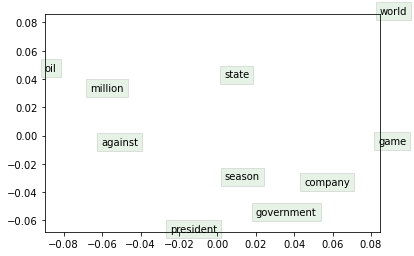

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

# concatenate the input and output word vectors
wordVectors = np.concatenate(
    (wordVectors[:nWords, :], wordVectors[nWords:, :]),
    axis=0)

visualizeWords = [
    'state', 'season', 'company', 'world', 'against', 
    'president', 'game', 'million', 'oil', 'government'
]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U, S, V = np.linalg.svd(covariance)
coord = temp.dot(U[:, 0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i, 0], coord[i, 1], visualizeWords[i],
             bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))

plt.savefig('word_vectors.png')
plt.show()

#### Run the following cell to obtain the k-nearest neighbors

In [80]:
centerVectors = wordVectors[:nWords, :]
outputVectors = wordVectors[nWords:, :]
for word in visualizeWords:
    idx = tokens[word]
    vec = outputVectors[idx]
    indices = knn(vec, outputVectors, 10)
    closed_words = [list(tokens.keys())[i] for i in indices]
    print('Word: "{}" is close to {}'.format(word, closed_words))

Word: "state" is close to ['state', 'research', 'mirrors', 'whitfield', 'perversely', 'tadic', 'community', 'company', 'tomko', 'science']
Word: "season" is close to ['season', 'repay', 'time', 'win', 'woman', 'nextel', 'holiday', 'check', 'english', 'cheney']
Word: "company" is close to ['company', 'united', 'when', 'hsbc', 'recruitment', 'beats', 'bonds', 'google', 'development', 'cost']
Word: "world" is close to ['world', 'public', 'help', 'electronic', 'wins', 'computers', 'titans', 'cents', 'potentially', 'another']
Word: "against" is close to ['against', 'primarily', 'rival', 'gallon', 'more', 'discounted', 'aspyr', 'nations', 'ghz', 'championship']
Word: "president" is close to ['president', 'lays', 'phrase', 'wrong', 'russell', 'shalal', 'giannini', 'trades', 'female', 'radioactive']
Word: "game" is close to ['game', 'msn', 'francona', 'red', 'theft', 'contentguard', 'fort', 'clothing', 'concerning', 'dorman']
Word: "million" is close to ['million', 'market', 'machines', 'soon'

## Analysis and Observation

It is observed that the the word embeddings result in to cluster in similar contexts. But considering that the vocabulary and the data is limited which introduces bias. Like 'season' word to associate closely to 'women' and 'government' associating closely to 'leg', which these can be reduced including sufficient large dataset from various sources. This also brings to the notice that media would refer to certain places, words, events, etc.